# Benefits of Contextualized ML

## Contextualized ML Enables High-Resolution Heterogeneity 
By sharing information between all contexts, contextualized learning is able to estimate heterogeneity at fine-grained resolution.
Cluster or cohort-based models treat every partition independently, limiting heterogeneity to
coarse-grained resolution where there are large enough cohorts for independent estimation.

### Problem Definition 
In this examples we are interested in learning Bayesian Networks (BNs) which are context-specific; i.e., theparameters and/or structure of the BNs may vary according to context. In this problem,for each observation $X∈R^p$, we also observe contextual data $C∈R^m$. 
We can describe this as factorizing $P(X, C) = \int_W{dW P(X|W)P(W|C)P(C)}$; where $P(X|W)=BN(X|W)$ is the distribution implied by BN structure W.
As a practical biological application, we can view X as gene expression, W as a gene regulatory network, and C as patient covariates which contextualize the network.

In [59]:
# We need a few libraries
import numpy as np # for linear algebra operations
import pandas as pd # for data manipulation 
import networkx as nx # for drawing graphs
import matplotlib.pyplot as plt # for drawing graphs
from rich import print # style 
%matplotlib inline
import warnings
warnings.filterwarnings("ignore", ".*UserWarning.*")

We then import the contextualized library, define $n$ simulated samples with context $C$. Gene expression $X$ depends on the BN defined by $W$, and is simulated using the helper function <i>simulate_linear_sem</i>, which simulates samples from linear structural equation modeling. 

In [60]:
#from contextualized import dev_dags
import sys
sys.path.insert(0, 'C:/Users/andre/OneDrive/Desktop/Nebula/Contextualized/')
import contextualized

simulate_linear_sem = contextualized.dags.graph_utils.simulate_linear_sem 

# number of samples
n = 1000
# C is the context
C = np.linspace(1, 5, n).reshape((n, 1))
# W is the adjacency matrix that defines the BN
W = np.zeros((4, 4, n, 1)) # 4 genes and n adjacency matrices
W[0, 1] = C - 2
W[2, 1] = C**2
W[3, 1] = C**3
W[3, 2] = C
W = np.squeeze(W)
W = np.transpose(W, (2, 0, 1))
# X is the gene expression
X = np.zeros((n, 4))
for i, w in enumerate(W):
    x = simulate_linear_sem(w, 1, "uniform", noise_scale=0.1)[0]
    X[i] = x

print(C.shape, W.shape, X.shape)

(1000, 1)
(1000, 4, 4)
(1000, 4)

In [61]:
from contextualized.easy import ContextualizedBayesianNetworks
cbn = ContextualizedBayesianNetworks(
    encoder_type='mlp', num_archetypes=16,
    n_bootstraps=2, archetype_dag_loss_type="DAGMA", archetype_alpha=0.,
    sample_specific_dag_loss_type="DAGMA", sample_specific_alpha=1e-1,
    learning_rate=1e-3)
cbn.fit(C, X, max_epochs=10)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name      | Type      | Params
----------------------------------------
0 | encoder   | MLP       | 1.8 K 
1 | explainer | Explainer | 256   
----------------------------------------
2.0 K     Trainable params
0         Non-trainable params
2.0 K     Total params
0.008     Total estimated model params size (MB)


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name      | Type      | Params
----------------------------------------
0 | encoder   | MLP       | 1.8 K 
1 | explainer | Explainer | 256   
----------------------------------------
2.0 K     Trainable params
0         Non-trainable params
2.0 K     Total params
0.008     Total estimated model params size (MB)


Now, if we consider a constant $C$, we are indirectly defining a population model. We use this idea to compare the performance of contextualized against not-contextualized BNs.

In [62]:
const_C = np.ones((n, 1))
print(const_C.shape, W.shape, X.shape)

(1000, 1)
(1000, 4, 4)
(1000, 4)

In [63]:
bn = ContextualizedBayesianNetworks(
    encoder_type='mlp', num_archetypes=16,
    n_bootstraps=2, archetype_dag_loss_type="DAGMA", archetype_alpha=0.,
    sample_specific_dag_loss_type="DAGMA", sample_specific_alpha=1e-1,
    learning_rate=1e-3)
bn.fit(const_C, X, max_epochs=10)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name      | Type      | Params
----------------------------------------
0 | encoder   | MLP       | 1.8 K 
1 | explainer | Explainer | 256   
----------------------------------------
2.0 K     Trainable params
0         Non-trainable params
2.0 K     Total params
0.008     Total estimated model params size (MB)


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name      | Type      | Params
----------------------------------------
0 | encoder   | MLP       | 1.8 K 
1 | explainer | Explainer | 256   
----------------------------------------
2.0 K     Trainable params
0         Non-trainable params
2.0 K     Total params
0.008     Total estimated model params size (MB)


In [64]:
# We can measure Mean-Squared Error to measure likelihood of X under predicted networks.
c_mses = np.mean(cbn.measure_mses(C, X))
mses = np.mean(bn.measure_mses(C, X))
print(f'[bold green]Contextualized Model\'s Mean Squared Error = [bold cyan]{c_mses:.2}')
print(f'[bold green]Not-Contextualized Model\'s Mean Squared Error = [bold cyan]{mses:.2}')

Contextualized Model's Mean Squared Error = 1.4e+04

Not-Contextualized Model's Mean Squared Error = 5.7e+04

 Comparison of inferred BNs

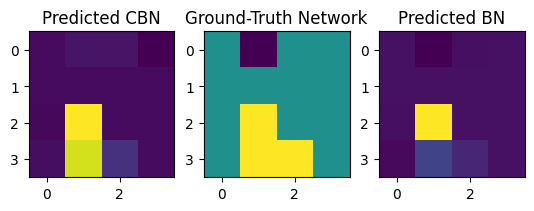

In [68]:
# Predict and visualize network
predicted_contextualized_networks = cbn.predict_networks(C)
predicted_networks = bn.predict_networks(C)
print(f'[bold green] Comparison of inferred BNs')
f, axarr = plt.subplots(1, 3)
axarr[0].imshow(predicted_contextualized_networks[0])
axarr[1].imshow(W[0])
axarr[2].imshow(predicted_networks[0])
axarr[0].set_title("Predicted CBN")
axarr[1].set_title("Ground-Truth Network")
axarr[2].set_title("Predicted BN")
print()

## Contextualized ML Enables Analysis of Latent Processes
Cluster or cohort models are inferred by partitioning data into groups, assumed to be iid, and estimating models for each groups. This
is only likely to be satisfied when contexts are discrete, low-dimensional, and every context-specific
population is well observed. In real life, contexts are often continuous, high dimensional, and sparsely
observed. When cluster or cohort approaches are applied in these circumstances, downstream modeling tasks are distorted by mis-specification, where many non-id samples are funneled into a single model. Consequently, there are no theoretical guarantees in many real life circumstances about how
well a cluster or cohort model can represent heterogeneous populations. Alternatively, contextualized
learning provides a way to estimate latent, non-id models for all samples with minimal assumptions
about the grouping or clustering of these samples, or the functional relationship between latent models and contexts. Samples can then be grouped on the basis of model parameters and distributional
differences to produce clusters in the latent model space underlying each sample. Contextualized ML
intuitively recovers latent structures underlying data generation in a way a priori clustering cannot. Allowing downstream models to determine the grouping of samples rather than upstream contexts replaces
traditional cluster analysis with contextualized analysis clusters.

Following the example depicted above, let's suppose the context $C$ of the gene expression $X$ is defined by some covariates $Z$. <br>
The context $C$ of each individual is modeled by $C = \beta(Z) + \epsilon$

In [74]:
# number of samples
n = 1000
# Covariates Z
Z = np.random.normal(-1, 1, (n, 5))
# beta
beta = np.random.normal(-1, 1, (5, 1))
# C is the context
C = np.matmul(Z, beta)
# W is the adjacency matrix that defines the BN
W = np.zeros((4, 4, n, 1)) # 4 genes and n adjacency matrices
W[0, 1] = C - 2
W[2, 1] = C**2
W[3, 1] = C**3
W[3, 2] = C
W = np.squeeze(W)
W = np.transpose(W, (2, 0, 1))
# X is the gene expression
X = np.zeros((n, 4))
for i, w in enumerate(W):
    x = simulate_linear_sem(w, 1, "uniform", noise_scale=0.1)[0]
    X[i] = x

print(C.shape, W.shape, X.shape)

(1000, 1)
(1000, 4, 4)
(1000, 4)

In [75]:
cbn = ContextualizedBayesianNetworks(
    encoder_type='mlp', num_archetypes=16,
    n_bootstraps=2, archetype_dag_loss_type="DAGMA", archetype_alpha=0.,
    sample_specific_dag_loss_type="DAGMA", sample_specific_alpha=1e-1,
    learning_rate=1e-3)
cbn.fit(C, X, max_epochs=10)
const_C = np.ones((n, 1))
bn = ContextualizedBayesianNetworks(
    encoder_type='mlp', num_archetypes=16,
    n_bootstraps=2, archetype_dag_loss_type="DAGMA", archetype_alpha=0.,
    sample_specific_dag_loss_type="DAGMA", sample_specific_alpha=1e-1,
    learning_rate=1e-3)
bn.fit(const_C, X, max_epochs=10)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name      | Type      | Params
----------------------------------------
0 | encoder   | MLP       | 1.8 K 
1 | explainer | Explainer | 256   
----------------------------------------
2.0 K     Trainable params
0         Non-trainable params
2.0 K     Total params
0.008     Total estimated model params size (MB)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name      | Type      | Params
----------------------------------------
0 | encoder   | MLP       | 1.8 K 
1 | explainer | Explainer | 256   
----------------------------------------
2.0 K     Trainable params
0         Non-trainable params
2.0 K     Total params
0.008     Total estimated model params size (MB)
GPU available: False, used: False
TPU available: False, using: 0 TPU c

In [76]:
# We can measure Mean-Squared Error to measure likelihood of X under predicted networks.
c_mses = np.mean(cbn.measure_mses(C, X))
mses = np.mean(bn.measure_mses(C, X))
print(f'[bold green]Contextualized Model\'s Mean Squared Error = [bold cyan]{c_mses:.2}')
print(f'[bold green]Not-Contextualized Model\'s Mean Squared Error = [bold cyan]{mses:.2}')

Contextualized Model's Mean Squared Error = 6.7e+07

Not-Contextualized Model's Mean Squared Error = 7.9e+08

## Contextualized ML Interpolates Between Observed Contexts 
By learning to translate contextual information into model parameters, contextualized models learn about the meta-distribution of
contexts. As a result, contextualized models can adapt to contexts which were never observed
in the training data by interpolating between observed contexts or extrapolating to new contexts.

Le's assume we observe a certain set of contexts in our initial population, how well does the contextualized model generalize to new/unobserved contexts?

In [79]:
# number of samples
n = 2000
# C is the context
# C in [1,2] & [5,6] for the initial population
# C in [2,5] for the unobserved population
C = np.concatenate([np.linspace(1, 2, n//4), np.linspace(5, 6, n//4), np.linspace(2, 5, n//2)]).reshape((n, 1))
# W is the adjacency matrix that defines the BN
W = np.zeros((4, 4, n, 1)) # 4 genes and n adjacency matrices
W[0, 1] = C - 2
W[2, 1] = C**2
W[3, 1] = C**3
W[3, 2] = C
W = np.squeeze(W)
W = np.transpose(W, (2, 0, 1))
# X is the gene expression
X = np.zeros((n, 4))
for i, w in enumerate(W):
    x = simulate_linear_sem(w, 1, "uniform", noise_scale=0.1)[0]
    X[i] = x
print(C.shape, W.shape, X.shape)

(2000, 1)
(2000, 4, 4)
(2000, 4)

In [81]:
cbn = ContextualizedBayesianNetworks(
    encoder_type='mlp', num_archetypes=16,
    n_bootstraps=2, archetype_dag_loss_type="DAGMA", archetype_alpha=0.,
    sample_specific_dag_loss_type="DAGMA", sample_specific_alpha=1e-1,
    learning_rate=1e-3)
cbn.fit(C[:n//2], X[:n//2], max_epochs=10)
const_C = np.ones((n//2, 1))
bn = ContextualizedBayesianNetworks(
    encoder_type='mlp', num_archetypes=16,
    n_bootstraps=2, archetype_dag_loss_type="DAGMA", archetype_alpha=0.,
    sample_specific_dag_loss_type="DAGMA", sample_specific_alpha=1e-1,
    learning_rate=1e-3)
bn.fit(const_C, X[:n//2], max_epochs=10)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name      | Type      | Params
----------------------------------------
0 | encoder   | MLP       | 1.8 K 
1 | explainer | Explainer | 256   
----------------------------------------
2.0 K     Trainable params
0         Non-trainable params
2.0 K     Total params
0.008     Total estimated model params size (MB)
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name      | Type      | Params
----------------------------------------
0 | encoder   | MLP       | 1.8 K 
1 | explainer | Explainer | 256   
----------------------------------------
2.0 K     Trainable params
0         Non-trainable params
2.0 K     Total params
0.008     Total estimated model params size (MB)
GPU available: False, used: False
TPU available: False, using: 0 TPU c

In [82]:
# We can measure Mean-Squared Error to measure likelihood of X under predicted networks.
c_mses = np.mean(cbn.measure_mses(C[n//2:], X[n//2:]))
mses = np.mean(bn.measure_mses(C[n//2:], X[n//2:]))
print(f'[bold green]Contextualized Model\'s Mean Squared Error = [bold cyan]{c_mses:.2}')
print(f'[bold green]Not-Contextualized Model\'s Mean Squared Error = [bold cyan]{mses:.2}')

Contextualized Model's Mean Squared Error = 3.8e+04

Not-Contextualized Model's Mean Squared Error = 2.2e+05